## Self-Taught Learning (Auto Encoder)

### Developer: Mayana Mohsin Khan

### Loading packages

In [1]:
# for plotting
library('ggplot2') 
library('gridExtra')

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'gridExtra' was built under R version 3.6.3"

In [2]:
# for deep learning
options(warn=-1)
library(h2o)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



In [3]:
# Create a local H2o host
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\MOHSIN~1\AppData\Local\Temp\RtmpmsW8Bg\file2d3826ef1a0c/h2o_Mohsin_Khan_started_from_r.out
    C:\Users\MOHSIN~1\AppData\Local\Temp\RtmpmsW8Bg\file2d3870c1303/h2o_Mohsin_Khan_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 696 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.4 
    H2O cluster version age:    11 days  
    H2O cluster name:           H2O_started_from_R_Mohsin_Khan_rtv739 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   5.33 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy: 

In [4]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
error.rate <- function(Y1, T1){
    if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
    }
    return (sum(T1!=Y1)/nrow(T1))
}

In [5]:
# Students: Use the "absolute" path to the datasets on your machine (important)
labeled.frame <- h2o.importFile(path = 'C:/Users/Mohsin Khan/FIT Data Science Monash Resources/FIT5201/Assignment 2/Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = 'C:/Users/Mohsin Khan/FIT Data Science Monash Resources/FIT5201/Assignment 2/Task2C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = 'C:/Users/Mohsin Khan/FIT Data Science Monash Resources/FIT5201/Assignment 2/Task2C_test.csv' ,sep=',') 

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [6]:
labeled.frame[,1] <- as.factor(labeled.frame$label) # labeled dataset
unlabeled.frame[,1] <- NA 
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1]) # cmbine labelled and unlabbeled to create training set
test.frame[,1] <- as.factor(test.frame$label) # create the testing frame

In [25]:
options(warn=-1)
# Specify the number of hidden layers
# increment hidden layers from 20 to 400 with a step of 20 each iteration
hidden.layers <- seq(20,400,20) 

# Empty data frame to store errors
NN.autoencode.error <- data.frame('hidden.layers' = seq(20,400,20), # Number of hidden layers
                                 'reconstruction.error'=rep(0,20), # column to store reconstruction error for train datasamples
                                 '3L.NN.err'=rep(0,20), # column to store 3 layer Neural Network error
                                  'Self.thaught.err' = rep(0,20) # column to store self though NN error
                                 )
# build the Neural Net
for (i in 1:length(hidden.layers)){
    
    # question 2: Build Autoencoder
    NN.model.autoencoder <- h2o.deeplearning(    
        x = 2:ncol(train.frame), # select all pixels
        training_frame = train.frame, # specify the frame (imported file)    
        hidden = c(hidden.layers[i]), # number of layers and their units
        epochs = 20, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE,  # is it an autoencoder? Yes!
    )
    
    reconstruction.errors <- h2o.anomaly(NN.model.autoencoder,train.frame) # Calculate the reconstruction errors
    NN.autoencode.error[i,2] <- sqrt(sum(reconstruction.errors)) # Store the errors
    
    # questtion 4: Build 3 layer Neural Network
    NN.model.3LNN <- h2o.deeplearning(    
          x = 2:ncol(labeled.frame), # select all pixels + extra features
          y = 1,
          training_frame = labeled.frame, # specify the frame (imported file)    
          hidden = c(hidden.layers[i]), # number of layers and their units
          epochs = 30, # maximum number of epoches  
          activation = 'Tanh', # activation function 
          autoencoder = FALSE, # is it an autoencoder? Yes!
          l2 = 0.1
    )

    predict.3LNN <- h2o.predict(NN.model.3LNN, test.frame)$predict # get the predicition
    error.3LNN <- error.rate(test.frame$label, predict.3LNN) # calculate eror 
    NN.autoencode.error[i,3] <- error.3LNN # store the error
    
    # question 5: Build Selft Thaough Learning 
    # combine the original labels and autoencoded labels
    train.features  <- h2o.cbind(labeled.frame,h2o.deepfeatures(NN.model.autoencoder, labeled.frame, layer=1))
    
    # train the model on combined features
    NN.model.self <- h2o.deeplearning(    
      x = 2:ncol(train.features), # select all pixels + extra features
      y = 1,
      training_frame = train.features, # specify the frame (imported file)    
      hidden = c(hidden.layers[i]), # number of layers and their units
      epochs = 30, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = FALSE, # is it an autoencoder? Yes!
      l2 = 0.1
    )
    
    # Build the model for test datset
    NN.model.test <- h2o.deeplearning(    
        x = 2:ncol(test.frame), # select all pixels
        training_frame = test.frame, # specify the frame (imported file)    
        hidden = c(hidden.layers[i]), # number of layers and their units
        epochs = 20, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE  # is it an autoencoder? Yes!
    )
    # Combine the test features and autoencoded test features
    test.features  <- h2o.cbind(test.frame,h2o.deepfeatures(NN.model.test, test.frame, layer=1))

    test.predict.self <- h2o.predict(NN.model.self, test.features)$predict # predict using the combined features and acutal features
    self.thought.error <- error.rate(test.features$label, test.predict.self) # Calculate the error
    NN.autoencode.error[i,4] <- self.thought.error # store the error
}


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [37]:
options(repr.plot.width=15, repr.plot.height = 8)
library(reshape2)

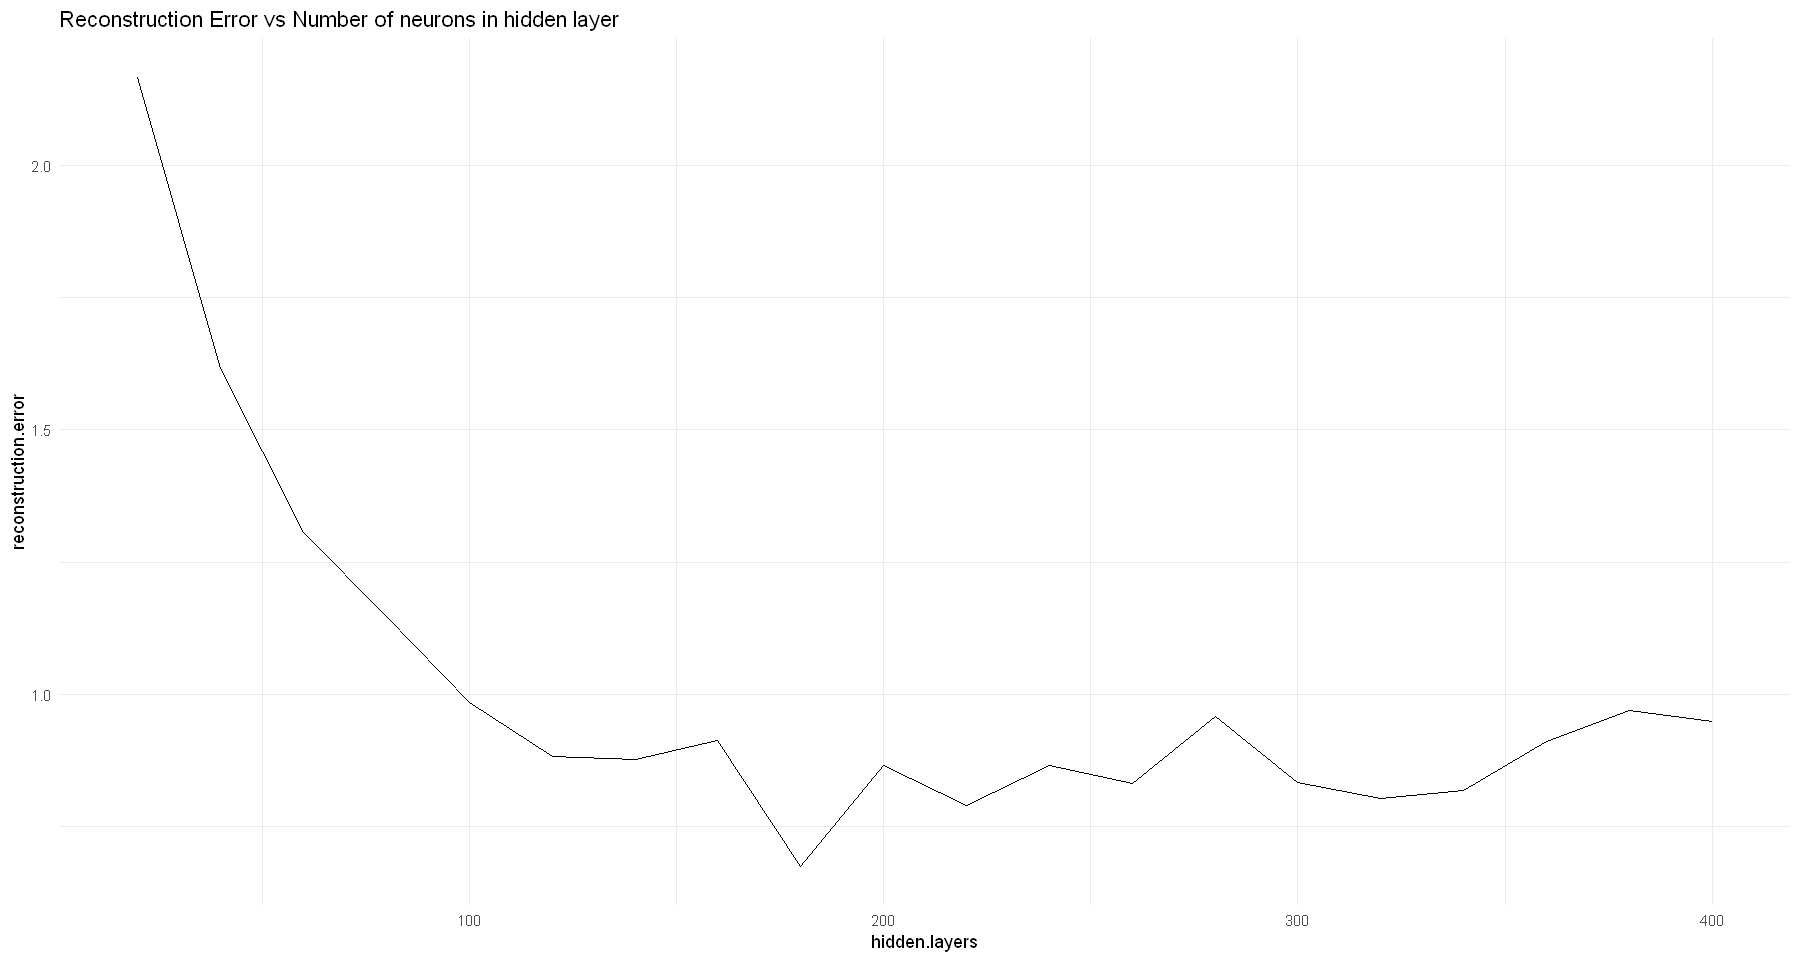

In [38]:
# Plotting the graphs
# Question 3: Reconstruction Error vs Number of neurons in hidden layer
ggplot(data = NN.autoencode.error, aes(x = hidden.layers, y = reconstruction.error)) + 
geom_line() + 
scale_color_discrete(guide = guide_legend(title = NULL)) + 
theme_minimal() +
ggtitle("Reconstruction Error vs Number of neurons in hidden layer")

From the Grpah for reconstruction error, we can see that the error rate decreases initially and then the takes a peek to is over all low when the number of hidden neuros is `180` which is visible in the graph. Later the graph more o less follow a stormy peaks of short high and lows but not vary much and settle into a smooth curve at the end.

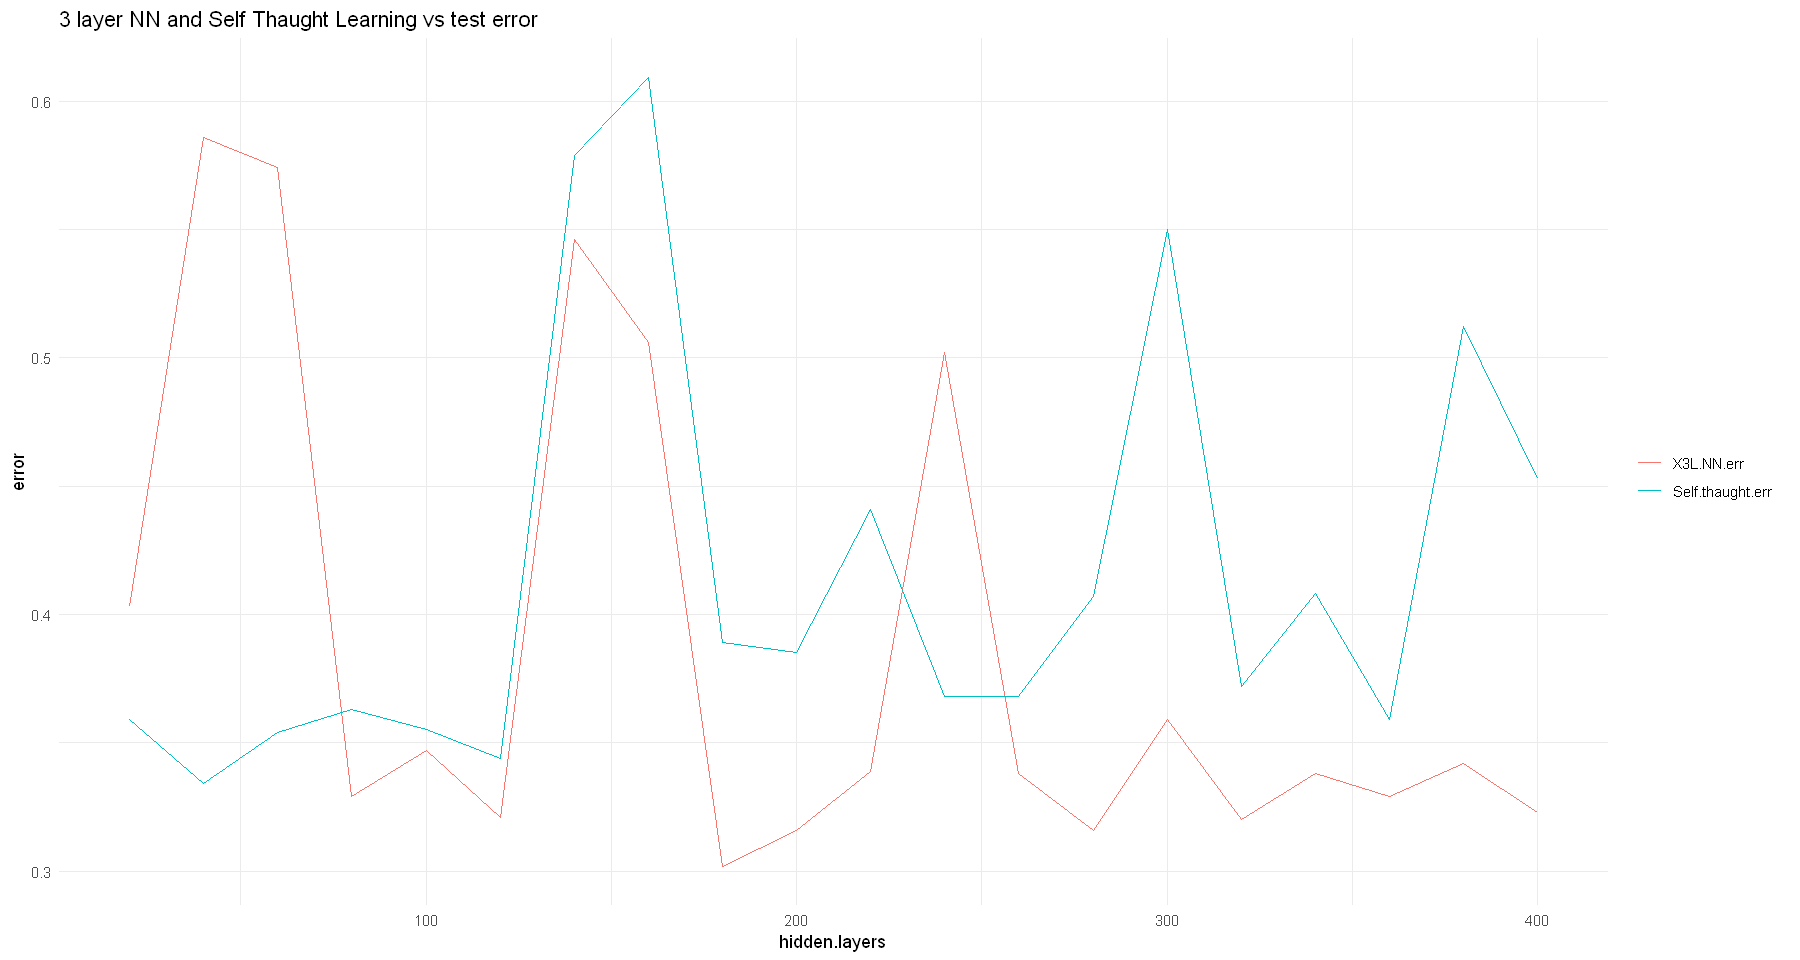

In [39]:
# reshaping the data for plotting
test.3nn.self.err.m <- melt(NN.autoencode.error[,c(-2)], id='hidden.layers') # reshape for visualization
names(test.3nn.self.err.m) <- c('hidden.layers', 'type', 'error')
# plot for testing errors for 3 layer neural network and self thaught neural network
ggplot(data=test.3nn.self.err.m, aes(x = hidden.layers, y = error, color=type)) + 
geom_line() +
scale_color_discrete(guide = guide_legend(title = NULL)) +
ggtitle("3 layer NN and Self Thaught Learning vs test error") + 
theme_minimal()

When it comes to neural networks, they are cable of taking more parameters then data itself. So in our 3 layer neural network, we take in all the parameters to create the neural net which in self-taught learning, it take it the parameters that are generated from the autoencoder as additional features. 

When we compare both the models, the 3 layer neural net gives better error better initially but then once the autoencoder features are added to self though net, it help in the classification task as the autoencoder gives out the most important features based on weights while disregarding al the other features which in practical sense reduces the error of self-thought net. SO the 3 layer notes keeps trains on all the features while the self-thought net trains on all the features plus powerful features thus reducing the error.
